In [1]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime,Trace
from obspy.geodetics.base import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
import matplotlib.pyplot as plt 
from obspy.signal.filter import envelope
import numpy as np
import os, glob
import pickle
client = Client("IRIS")
model = TauPyModel(model="iasp91")


In [16]:
starttime = UTCDateTime("2011-08-24")
endtime = UTCDateTime("2011-08-25")
Cata = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=6.5,latitude =41.115,longitude=43.8036,
                        minradius=80,maxradius=130,mindepth=100 )
eq_time= Cata[0].origins[0].time
eq_lat = Cata[0].origins[0].latitude
eq_lon = Cata[0].origins[0].longitude
depth  = Cata[0].origins[0].depth/1000

In [170]:
inventory = client.get_stations(network="IU", station="GNI",
                                starttime=starttime,endtime=endtime)
st_lat=inventory[0][0].latitude
st_lon=inventory[0][0].longitude
dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
deg = kilometers2degrees(dist/1000)
print(deg)

120.59210921225406


In [171]:
arrivals = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=deg,
                                  phase_list=["PKS","SKS",'SKKS'])
arr_SKS = arrivals[0].time
arr_SKKS = arrivals[1].time

In [172]:
st = client.get_waveforms(network='IU',station='GNI',location='00',
    channel="B*", starttime=eq_time+arr_SKS-100,endtime=eq_time+arr_SKS+300,attach_response=True)

In [173]:
# st.remove_response(pre_filt = [0.001,0.003,9,10],output='VEL')
st.detrend('linear')
st.detrend('demean')
st.taper(0.05,type='cosine')
st.filter('bandpass',freqmin=0.04,freqmax=0.125,corners=4,zerophase=True)

3 Trace(s) in Stream:
IU.GNI.00.BH1 | 2015-02-11T19:20:45.319539Z - 2015-02-11T19:27:25.269539Z | 20.0 Hz, 8000 samples
IU.GNI.00.BH2 | 2015-02-11T19:20:45.319536Z - 2015-02-11T19:27:25.269536Z | 20.0 Hz, 8000 samples
IU.GNI.00.BHZ | 2015-02-11T19:20:45.319538Z - 2015-02-11T19:27:25.269538Z | 20.0 Hz, 8000 samples

In [174]:
HHE = st.select(component='2')[0].data
HHN = st.select(component='1')[0].data
HHZ = st.select(component='Z')[0].data
HHR,HHT = rotate_ne_rt(HHN,HHE,baz)

In [175]:
signalbegin = arr_SKS -5
signalend   = arr_SKS +25
noiseend    = arr_SKS -20 
noisebegin  = arr_SKS -20-60


dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal_SKS = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)


signal_envelope_SKS = envelope(signal_SKS.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope_SKS**2)
cal_noise = sum(noise_envelope**2)

SNR = cal_signal * 2 / cal_noise
print(round(SNR,0))

76.0


In [176]:
signalbegin = arr_SKKS -5
signalend   = arr_SKKS +25
noiseend    = arr_SKS -20 
noisebegin  = arr_SKS -20-60
dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal_SKKS = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)


signal_envelope_SKKS = envelope(signal_SKKS.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope_SKKS**2)
cal_noise = sum(noise_envelope**2)

SKKS_SNR = cal_signal * 2 / cal_noise
print(round(SKKS_SNR,0))

107.0


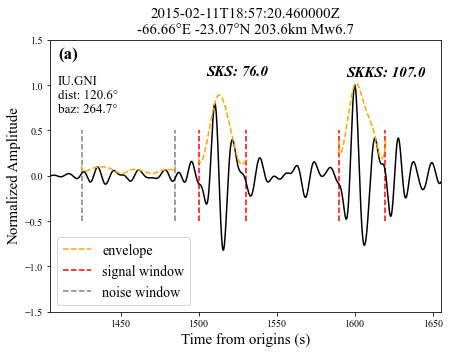

In [177]:
time = st[0].times(reftime=eq_time)
ylim=1
plt.figure(figsize=(7,5))
plt.rcParams["font.family"] = "Times New Roman"


plt.title(f'{eq_time}\n{round(eq_lon,2)}°E {round(eq_lat,2)}°N {depth}km Mw{Cata[0].magnitudes[0].mag}', fontsize=15)
# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = arr_SKS -5,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--', label='signal window')
plt.vlines(x = arr_SKS +25,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = arr_SKKS -5,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = arr_SKKS +25,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-ylim*0.5,ymax=ylim*0.5,color='grey',ls='--', label='noise window')
plt.vlines(x = noisebegin,ymin=-ylim*0.5,ymax=ylim*0.5,color='grey',ls='--')
plt.plot(time,HHR/max(HHR),'k')
plt.plot(signal_SKS.times(reftime=eq_time),signal_envelope_SKS/max(HHR),c='orange',ls='--')
plt.plot(signal_SKKS.times(reftime=eq_time),signal_envelope_SKKS/max(HHR),c='orange',ls='--', label='envelope')
plt.plot(noise.times(reftime=eq_time),noise_envelope/max(HHR),c='orange',ls='--')

plt.xlim(arr_SKS-100,arr_SKS+150)
plt.text(x = arr_SKS, y = ylim*1.1, s = f'SKS: {round(SNR,0)}', fontsize=15, fontstyle= 'italic', fontweight='bold')
plt.text(x = arr_SKKS, y = ylim*1.1, s = f'SKKS: {round(SKKS_SNR,0)}', fontsize=15, fontstyle= 'italic', fontweight='bold')
plt.xlabel('Time from origins (s)', fontsize=15)
plt.ylabel('Normalized Amplitude', fontsize=15)
plt.legend(fontsize=14, loc=3)

plt.ylim(-1*ylim*1.5,ylim*1.5)
plt.text(arr_SKS-95, ylim*1.3, f'(a)', fontsize=17, fontweight='bold')
plt.text(arr_SKS-95, ylim*0.7, f'IU.GNI\ndist: {round(deg,1)}°\nbaz: {round(baz,1)}°', fontsize=13)


plt.savefig('SNR_GNI.png',dpi=200, bbox_inches='tight')


## MAGY

In [6]:
path = '/Volumes/home/06_NTU_thesis/Thesis_figure/Ch3/non-Null/20110824_174611'

In [3]:
st_lat = 41.0353; st_lon = 44.4009
dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
deg = kilometers2degrees(dist/1000)
print(deg)

120.41424127566884


In [4]:
arrivals = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=deg,
                                  phase_list=["PKS","SKS",'SKKS'])
arr_SKS = arrivals[0].time
arr_SKKS = arrivals[1].time

In [13]:
st =  pickle.load(open(f'{path}/LQT_data.pkl', "rb"))
# st.
HHR = st.select(component='Q')[0].data * -1
HHT = st.select(component='T')[0].data 


In [12]:
signal_SKS

... | 2015-02-11T19:22:19.653475Z - 2015-02-11T19:22:19.653475Z | 10.0 Hz, 0 samples

In [18]:
signalbegin = arr_SKS -5
signalend   = arr_SKS +25
noiseend    = arr_SKS -20 
noisebegin  = arr_SKS -20-60


dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal_SKS = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)

signal_envelope_SKS = envelope(signal_SKS.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope_SKS**2)
cal_noise = sum(noise_envelope**2)

SNR = cal_signal * 2 / cal_noise
print(round(SNR,0))

40.0


In [162]:
signalbegin = arr_SKKS -5
signalend   = arr_SKKS +25
dt = st[0].stats.sampling_rate
temp_tr = Trace(data=HHR)
temp_tr.stats.delta = 1/dt
temp_tr.stats.starttime = st[0].stats.starttime
signal_SKKS = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
noise = temp_tr.slice(eq_time+noisebegin,eq_time+noiseend)


signal_envelope_SKKS = envelope(signal_SKKS.data)
noise_envelope = envelope(noise.data)

cal_signal = sum(signal_envelope_SKKS**2)
cal_noise = sum(noise_envelope**2)

SKKS_SNR = cal_signal * 2 / cal_noise
print(round(SKKS_SNR,0))

40.0


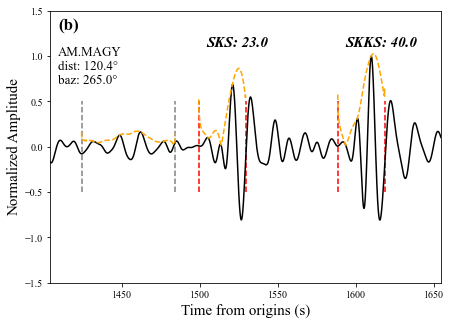

In [169]:
time = st[0].times(reftime=eq_time)
ylim=1
plt.figure(figsize=(7,5))
plt.rcParams["font.family"] = "Times New Roman"

# plt.vlines(x = arr_SKS,ymin=-4*10**-6,ymax=4*10**-6,color='r',ls='--')
plt.vlines(x = arr_SKS -5,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = arr_SKS +25,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = arr_SKKS -5,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = arr_SKKS +25,ymin=-ylim*0.5,ymax=ylim*0.5,color='r',ls='--')
plt.vlines(x = noiseend,ymin=-ylim*0.5,ymax=ylim*0.5,color='grey',ls='--')
plt.vlines(x = noisebegin,ymin=-ylim*0.5,ymax=ylim*0.5,color='grey',ls='--')
plt.plot(time,HHR/max(HHR),'k')
plt.plot(signal_SKS.times(reftime=eq_time),signal_envelope_SKS/max(HHR),c='orange',ls='--')
plt.plot(signal_SKKS.times(reftime=eq_time),signal_envelope_SKKS/max(HHR),c='orange',ls='--', label='envelope')
plt.plot(noise.times(reftime=eq_time),noise_envelope/max(HHR),c='orange',ls='--')

plt.xlim(arr_SKS-100,arr_SKS+150)
plt.text(x = arr_SKS, y = ylim*1.1, s = f'SKS: {round(SNR,0)}', fontsize=15, fontstyle= 'italic', fontweight='bold')
plt.text(x = arr_SKKS, y = ylim*1.1, s = f'SKKS: {round(SKKS_SNR,0)}', fontsize=15, fontstyle= 'italic', fontweight='bold')
plt.xlabel('Time from origins (s)', fontsize=15)
plt.ylabel('Normalized Amplitude', fontsize=15)


plt.ylim(-1*ylim*1.5,ylim*1.5)
plt.text(arr_SKS-95, ylim*1.3, f'(b)', fontsize=17, fontweight='bold')
plt.text(arr_SKS-95, ylim*0.7, f'AM.MAGY\ndist: {round(deg,1)}°\nbaz: {round(baz,1)}°', fontsize=13)


plt.savefig('SNR_MAGY.png',dpi=200, bbox_inches='tight')


In [68]:
SKKS_SNR/2.26122E+21

1.7473029796517668e-20